## To what extent logistic regression can do?

### load and clean data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

input_path_thyroid = '../../input/uci_thyroid'
tsh_transform = lambda x: np.log(1e-5 + x)
col_names = [
    'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
    'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
    'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
    'psych', 'TSH_log', 'T3', 'TT4', 'T4U', 
    'FTI'
]
class_names = ['normal', 'hyper', 'hypo']
df_thyr = [
    pd.read_csv(
        f'{input_path_thyroid}/ann-{tag}.data', header=None, names=col_names+['class'],
        delim_whitespace=True
    )
    for tag in ['train', 'test']
]
df_thyr = pd.concat([
    pd.concat(df_thyr, axis=0, ignore_index=True), 
    pd.Series([0]*len(df_thyr[0]) + [1]*len(df_thyr[1]), name='test')
], axis=1)
df_thyr = df_thyr.drop_duplicates()
del df_thyr['hypopituitary']
df_thyr['TSH_log'] = tsh_transform(df_thyr['TSH_log'])

df_thyr_train, df_thyr_test = df_thyr[df_thyr['test'] == 0], df_thyr[df_thyr['test'] == 1]

X_train, y_train = df_thyr_train.iloc[:, :-2], df_thyr_train['class']
X_test,  y_test  =  df_thyr_test.iloc[:, :-2],  df_thyr_test['class']

## Naive trial

### with a glance on various classification metrics

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    f1_score, precision_recall_curve, roc_curve, auc
)

**overview on popular metrics**

In [46]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)
print(f'accuracy: {100*accuracy_score(y_train, model.predict(X_train)):.2f}%')
print(f'accuracy: {100*accuracy_score(y_test, y_pred := model.predict(X_test)):.2f}%')

accuracy: 98.38%
accuracy: 97.40%


In [47]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.7949    0.8493    0.8212        73
           2     0.8210    0.7514    0.7847       177
           3     0.9862    0.9893    0.9877      3170

    accuracy                         0.9740      3420
   macro avg     0.8673    0.8633    0.8645      3420
weighted avg     0.9735    0.9740    0.9737      3420



**confusion matrix**

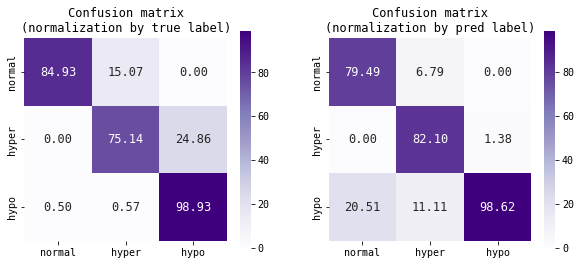

In [73]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

ax = axs[0]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='true'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by true label)', fontsize=12)

ax = axs[1]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='pred'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by pred label)', fontsize=12)


plt.show(); plt.close()

**roc curve and pecision-recall curve**

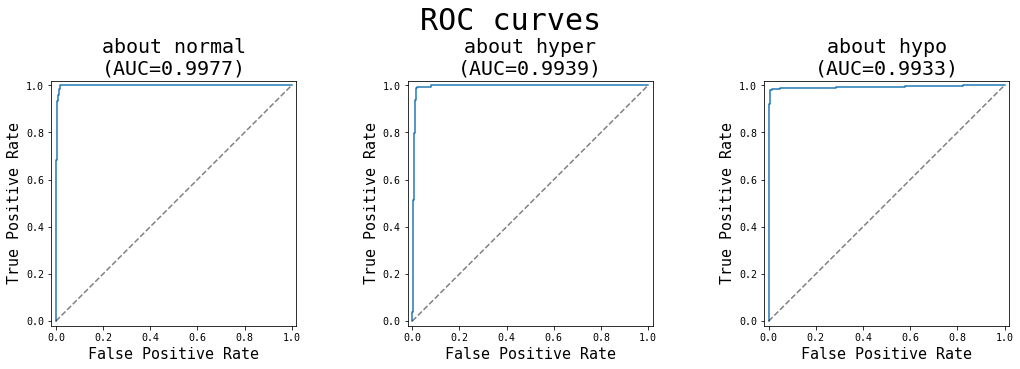

In [96]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    fpr, tpr, thres = roc_curve(y_test == i+1, model.predict_proba(X_test)[:, i])
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='#000000', linestyle='--', alpha=0.5)
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)
    ax.set_title(f'about {class_names[i]}\n(AUC={auc(fpr, tpr):.4f})', fontsize=20)
    ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
fig.suptitle('ROC curves', fontsize=30)
plt.tight_layout(); plt.show(); plt.close()

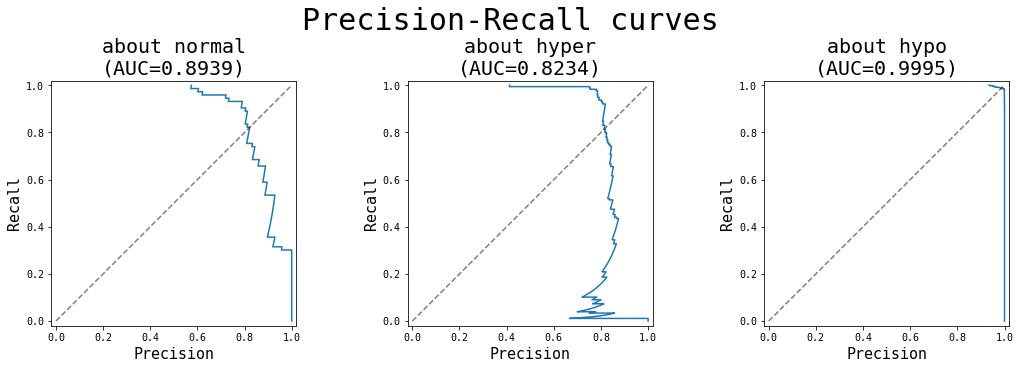

In [103]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    prec, rec, thres = precision_recall_curve(y_test == i+1, model.predict_proba(X_test)[:, i])
    ax.plot(prec, rec)
    ax.plot([0, 1], [0, 1], color='#000000', linestyle='--', alpha=0.5)
    ax.set_xlabel('Precision', fontsize=15)
    ax.set_ylabel('Recall', fontsize=15)
    ax.set_title(f'about {class_names[i]}\n(AUC={auc(rec, prec):.4f})', fontsize=20)
    ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
fig.suptitle('Precision-Recall curves', fontsize=30)
plt.tight_layout(); plt.show(); plt.close()

### model interpretation

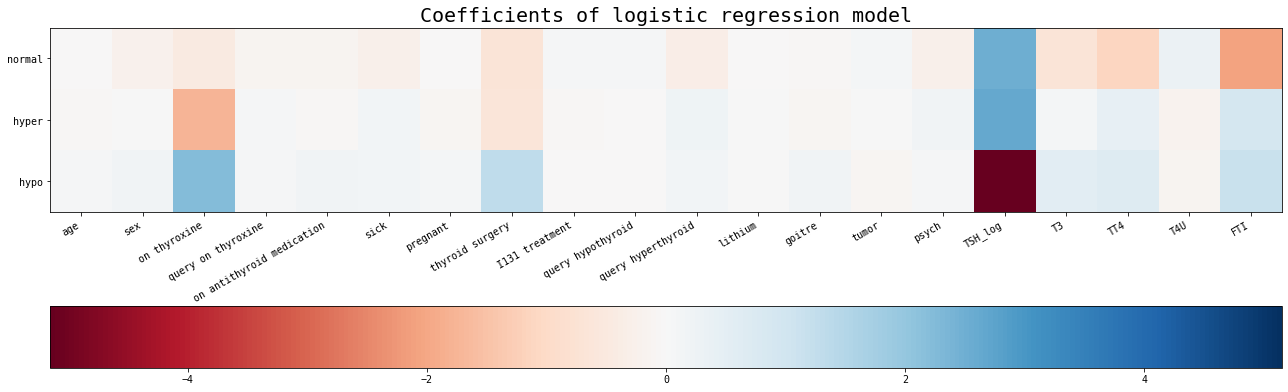

In [41]:
coef = model[-1].coef_
m = np.max(np.abs(coef))

fig, ax = plt.subplots(figsize=(18, 9))
img = plt.imshow(coef, vmin=-m, vmax=m, cmap='RdBu')
plt.colorbar(img, orientation='horizontal')
ax.set_xticks(np.arange(X_train.shape[1]))
ax.set_xticklabels(X_train.columns, ha='right', rotation=30)
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['normal', 'hyper', 'hypo'])
ax.set_title('Coefficients of logistic regression model', fontsize=20)
plt.tight_layout(); plt.show(); plt.close()

## What if weight is balanced?

In [105]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',
        random_state=42
    )
)
model.fit(X_train, y_train)
print(f'accuracy: {100*accuracy_score(y_train, model.predict(X_train)):.2f}%')
print(f'accuracy: {100*accuracy_score(y_test, y_pred := model.predict(X_test)):.2f}%')

accuracy: 97.14%
accuracy: 95.47%


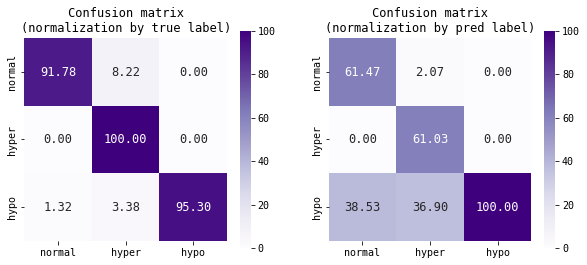

In [106]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

ax = axs[0]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='true'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by true label)', fontsize=12)

ax = axs[1]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='pred'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by pred label)', fontsize=12)


plt.show(); plt.close()

## What if regularization is L1(Lasso)?

In [112]:
from sklearn.linear_model import SGDClassifier

model = make_pipeline(
    StandardScaler(),
    SGDClassifier(
        loss='log',
        penalty='l1',
        max_iter=1000, 
        random_state=42
    )
)
model.fit(X_train, y_train)
print(f'accuracy: {100*accuracy_score(y_train, model.predict(X_train)):.2f}%')
print(f'accuracy: {100*accuracy_score(y_test, y_pred := model.predict(X_test)):.2f}%')

accuracy: 98.60%
accuracy: 97.81%


In [115]:
model[-1].coef_

array([[-2.89962669e+00, -1.99947068e+00, -4.49202026e+00,
        -6.22560280e+01, -6.29287892e+01, -9.62517337e+00,
        -5.11948232e+01, -1.31595699e+01,  0.00000000e+00,
         8.52967027e-01, -1.57273079e+01, -8.27089925e+00,
        -7.98117204e+01,  0.00000000e+00,  0.00000000e+00,
         2.61001370e+01, -4.31276761e+00, -2.34680326e+01,
         6.52276534e+00, -3.95358501e+01],
       [ 0.00000000e+00, -1.26906298e-01, -7.50051257e+01,
         1.10417145e-02, -9.61193751e-01,  0.00000000e+00,
        -6.47638975e+01, -6.78760893e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.51140942e+01,  2.19326403e-01,  1.35168369e-01,
         3.88948174e+00,  0.00000000e+00,  2.07831207e+00,
        -1.30962565e+00, -1.43251339e+00],
       [ 6.22317060e-01,  1.16658259e-01,  5.09512753e+01,
         4.34670197e-01,  2.73365104e+00,  6.02677508e-01,
         3.77243293e+00,  2.38977961e+01,  0.00000000e+00,
         1.95152188e+00,  0.0

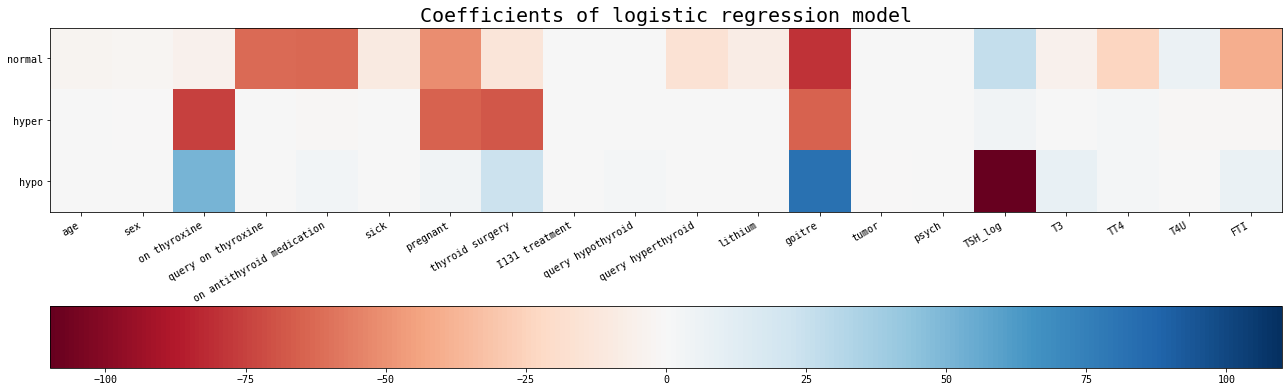

In [113]:
coef = model[-1].coef_
m = np.max(np.abs(coef))

fig, ax = plt.subplots(figsize=(18, 9))
img = plt.imshow(coef, vmin=-m, vmax=m, cmap='RdBu')
plt.colorbar(img, orientation='horizontal')
ax.set_xticks(np.arange(X_train.shape[1]))
ax.set_xticklabels(X_train.columns, ha='right', rotation=30)
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['normal', 'hyper', 'hypo'])
ax.set_title('Coefficients of logistic regression model', fontsize=20)
plt.tight_layout(); plt.show(); plt.close()

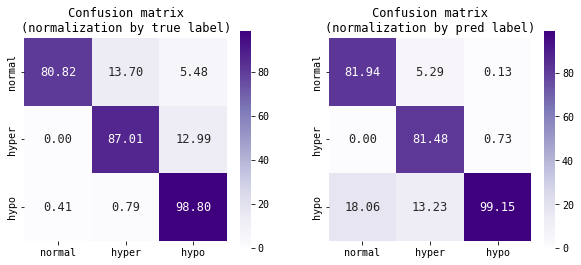

In [116]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

ax = axs[0]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='true'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by true label)', fontsize=12)

ax = axs[1]
sns.heatmap(
    1e2*confusion_matrix(y_test, y_pred, normalize='pred'), fmt='.2f',
    cmap='Purples', annot=True, annot_kws={'fontsize': 12}, square=True,
    xticklabels=class_names, yticklabels=class_names, ax=ax
)
ax.set_title('Confusion matrix\n(normalization by pred label)', fontsize=12)


plt.show(); plt.close()